**Цель:**

В процессе выполнения задания вы проведёте первичный анализ поставленной задачи и выберете подходящий алгоритм.
Для успешного выполнения задания вам потребуется:

    понимание отличий между средами с дискретными и непрерывным набором действий;
    навык оценки задачи и выбора подходящего алгоритма;
    навык разработки несложных алгоритмов на Python;
    навык реализации нейронных сетей с использованием фреймворка PyTorch;
    навык отладки алгоритма и выбора оптимальных гиперпараметров.

**Пошаговая инструкция:**

    реализуйте алгоритм DQN с реплей буффером и мягким обновлением целевой сети;
    обучите агента в среде Lunar Lander;
    представьте исходный код, обученного агента и график средней награды за эпизод и средней наградой за 100 эпизодов по мере обучения агента.

Для запуска проекта потребуется установка устаеновка дополнительных библиотек, наже они перечислены, если будет ошибка то необходимо установить недостающие.

!pip install swig

!pip install Box2D gym

!pip install --user gymnasium[box2d]

!pip install moviepy

Произведем импорт неоходимых библиотек. 

In [1]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

import cv2



Создадим нейронную сеть для аппроксимации Q-функции

In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


Напишем агента DQN

In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Гиперпараметры
        self.gamma = 0.99  # коэффициент дисконтирования
        self.lr = 0.001    # скорость обучения
        self.batch_size = 64
        self.buffer_size = int(1e5)
        self.update_every = 4
        self.tau = 1e-3    # параметр для мягкого обновления

        # Инициализация сети
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        # Replay memory
        self.memory = deque(maxlen=self.buffer_size)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0 and len(self.memory) > self.batch_size:
            experiences = self._sample_experiences()
            self.learn(experiences)

    def _sample_experiences(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.from_numpy(np.vstack(states)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)
        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def act(self, state, eps=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # Получаем максимальное Q значение для следующего состояния из целевой сети
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # Вычисляем целевые Q значения
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Получаем текущие Q значения из локальной сети
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Вычисляем loss и делаем шаг оптимизации
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Обновляем целевую сеть с использованием мягкого обновления
        self._soft_update(self.qnetwork_local, self.qnetwork_target)

    def _soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


Определим цикл обучения агента.

In [4]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    for i_episode in range(1, n_episodes+1):
        state = env.reset()[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay * eps)

        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")
        if i_episode % 100 == 0:
            print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}")
        if np.mean(scores_window) >= 200.0:
            print(f"\nEnvironment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_window):.2f}")
            break
    
    return scores


Запустим обучение. 

In [9]:
env = gym.make('LunarLander-v2')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
seed = 0
agent = DQNAgent(state_size, action_size, seed)

scores = dqn(agent)



Episode 100	Average Score: -150.71
Episode 200	Average Score: -86.912
Episode 300	Average Score: -55.77
Episode 400	Average Score: -22.54
Episode 500	Average Score: 97.970
Episode 600	Average Score: 184.55
Episode 630	Average Score: 202.12
Environment solved in 630 episodes!	Average Score: 202.12


Визуализируем рещультаты. 

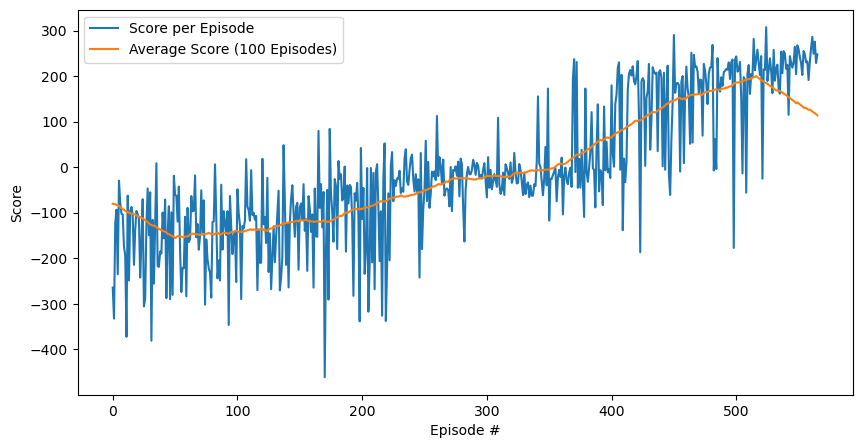

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(scores)), scores, label='Score per Episode')
plt.plot(np.arange(len(scores)), np.convolve(scores, np.ones(100)/100, mode='same'), label='Average Score (100 Episodes)')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()


Для наглядной демонтрации создадим видео с результатом обучения модели. 

In [17]:

def record_video(env, agent, filename="lunar_lander_opencv.avi"):
    frames = []
    state = env.reset()[0]
    done = False
    score = 0

    while not done:
        frame = env.render()  # Получаем изображение из среды
        frames.append(frame)

        action = agent.act(state, eps=0.0)  # Используем обученную сеть
        result = env.step(action)  # Получаем все возвращаемые значения
        
        # Проверка возвращаемых значений
        if len(result) == 5:
            state, reward, done, info, _ = result
        elif len(result) == 4:
            state, reward, done, info = result
        else:
            raise ValueError(f"Expected 4 or 5 values from step, but got {len(result)}")

        score += reward

    print(f"Final Score: {score}")

    # Определите параметры для видео
    fps = 30
    frame_size = (frames[0].shape[1], frames[0].shape[0])  # (width, height)

    # Создание объекта VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Кодек для MP4
    video_writer = cv2.VideoWriter(filename, fourcc, fps, frame_size)

    # Запись кадров в видеофайл
    for frame in frames:
        video_writer.write(frame)

    # Освобождение ресурсов
    video_writer.release()
    cv2.destroyAllWindows()

    env.close()

# Создание окружения с параметром render_mode
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Замените 'agent' на ваш реальный агент
# Пример использования функции с агентом
record_video(env, agent, filename="lunar_lander_opencv.avi")


Final Score: 282.45506406000766


## Заключение

Результаты показывают, что разработанный агент способен обучаться в среде LunarLander-v2, демонстрируя улучшение показателей на протяжении тренировки. Однако, для достижения более стабильных и высоких результатов требуется дальнейшая оптимизация гиперпараметров и увеличение числа тренировочных эпизодов. Также стохастическая природа среды вносит дополнительные сложности в оценку качества работы агента, что требует учета в будущем.